**Imports**

In [ ]:
!pip install pyccel
!pip install numba
import numpy as np
import scipy as sp
from scipy import special as ss
import scipy.linalg as lg
import matplotlib.pyplot as pl

import time
from time import process_time


from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types,pure


*transformation functions*

In [65]:

def JT(x):
  return sp.array([[1,2],[-1,0]])                          #Jacobien de FT
  
  
  
def F(x):
  return sp.array([x[0],(1-x[0])*x[1]])                    #Transformation de Duffy

**Pure python function**

In [66]:
def factorisation_pure(d,iteration,B0,B1,w0,w1,malphaBihaApp,grs):
  iteration=0
  q=d+1
  for alpha1 in range(0,d+1):
    for bita1 in range(0,d+1):
      c=0.
      for r in range(0,q):
        c=c+(grs*w1[r]*B1[r,alpha1]*B1[r,bita1])
      for alpha2 in range(0,d-alpha1+1):
        for bita2 in range(0,d-bita1+1):
          cMalphaBihaApp=0.
          for s in range(0,q):
            cMalphaBihaApp = cMalphaBihaApp+c*w0[s]*B0[s,d-alpha1,alpha2]*B0[s,d-bita1,bita2]
          malphaBihaApp[iteration]=((0.5)**3)*cMalphaBihaApp 
          iteration=iteration+1 
    

  return 0

**Numba accelerator**

In [67]:
@njit
def factorisation_numba(d,iteration,B0,w0,B1,w1,malphaBihaApp,grs):
  iteration=0
  q=d+1
  for alpha1 in range(0,d+1):
    for bita1 in range(0,d+1):
      c=0.
      for r in range(0,q):
        c=c+(grs*w1[r]*B1[r,alpha1]*B1[r,bita1])
      for alpha2 in range(0,d-alpha1+1):
        for bita2 in range(0,d-bita1+1):
          cMalphaBihaApp=0.
          for s in range(0,q):
            cMalphaBihaApp = cMalphaBihaApp+c*w0[s]*B0[s,d-alpha1,alpha2]*B0[s,d-bita1,bita2]
          malphaBihaApp[iteration]=((0.5)**3)*cMalphaBihaApp 
          iteration=iteration+1 
    

  return 0

**Pyccel accelerator**

In [68]:
@types('int','int','float[:,:,:]','float[:]','float[:,:]','float[:]','float[:]','float')
def factorisation_pyccel(d,iteration,B0,w0,B1,w1,malphaBihaApp,grs):
  iteration=0
  q=d+1
  for alpha1 in range(0,d+1):
    for bita1 in range(0,d+1):
      c=0.
      for r in range(0,q):
        c=c+(grs*w1[r]*B1[r,alpha1]*B1[r,bita1])
      for alpha2 in range(0,d-alpha1+1):
        for bita2 in range(0,d-bita1+1):
          cMalphaBihaApp=0.
          for s in range(0,q):
            cMalphaBihaApp = cMalphaBihaApp+c*w0[s]*B0[s,d-alpha1,alpha2]*B0[s,d-bita1,bita2]
          malphaBihaApp[iteration]=((0.5)**3)*cMalphaBihaApp 
          iteration=iteration+1 
    

  return 0


**Epyccel function**

In [69]:
factorisation=epyccel(factorisation_pyccel,language='fortran')

**Bernstein's function**

In [72]:
########################################## B[s,n,k] avec n entre 0 et degre pmax, k entre 0 et n ##################################################
C0=sp.diag(sp.ones(500))
C0[:,0]=sp.ones(500)
for n in range(1,500):                                   # Formule de pascal
     for m in range(1,n+1):
        C0[n,m]= C0[n-1,m-1]+C0[n-1,m] 
p=100
q=p+1
t0,w0=ss.roots_jacobi(q,0,0)  
ita0=(1/2)+0.5*t0
##########################################  analytique ############################
B=np.zeros((q,q,q))
star_temp1=process_time()
for s in range(q):
  x=ita0[s]
  for n in range(q):
    for k in range(n+1):
      B[s,n,k]=C0[n,k]*((1-x)**(n-k))*(x**k)
end_temp1=process_time()
##########################################  methode iterative #############################
B=np.zeros((q,q,q))
star_temp2=process_time()
for s in range(q):
  x=ita0[s]
  B[s,0,0]=1
  for n in range(1,q):
    B[s,n,0]=(1-x)*B[s,n-1,0]
    for k in range(1,n+1):
      B[s,n,k]=x*B[s,n-1,k-1]+(1-x)*B[s,n-1,k]
end_temp2=process_time()  


########################################## all_bernstein   #############################
B=np.zeros((q,q,q))
star_temp6=process_time()
for s in range(q):
  x=ita0[s]
  for n in range(q):
    b = np.zeros(q)
    b[0] = 1.
    x1 = 1.-x
    for j in range(1, n+1):
      saved = 0.
      for i in range(0, j):
        tmp = b[i]
        b[i] = saved + x1*tmp
        saved = x*tmp
      b[j] = saved 
    B[s,n,:]=b  
end_temp6=process_time()  



print('temps calcul analytique de B : ',end_temp1-star_temp1)
print('temps calcul itérative de B:  ',end_temp2-star_temp2)
print('temps calcul all_bernstein  B: ',end_temp6-star_temp6)
print('///////////////////// ////////////////////////////////////////////////////////////////////////\n')
########################################## B[s,k] avec  et k entre 0 et p ####################################################################
t1,w1=ss.roots_jacobi(q,1,0)  
ita1=(1/2)+0.5*t1
##########################################  analytique ############################
Bfix=np.zeros((q,q))
star_temp3=process_time()
for s in range(q):
  x=ita1[s]
  for k in range(q):
    Bfix[s,k]=C0[n,k]*((1-x)**(n-k))*(x**k)
end_temp3=process_time()
##########################################  methode iterative #############################
Bfix=np.zeros((q,q))
star_temp4=process_time()
for s in range(q):
  x=ita1[s]
  Bfix[s,0]=(1-x)**p
  for k in range(1,q):
    Bfix[s,k]=(x/(1-x))*((p-k+1)/k)*Bfix[s,k-1]
end_temp4=process_time() 

########################################## all_bernstein   #############################
Bfix=np.zeros((q,q))
star_temp5=process_time()
for s in range(q):
  x=ita1[s]
  b = np.zeros(q)
  b[0] = 1.
  x1 = 1.-x
  for j in range(1, q):
    saved = 0.
    for i in range(0, j):
      tmp = b[i]
      b[i] = saved + x1*tmp
      saved = x*tmp
    b[j] = saved
  Bfix[s,:]=b  
end_temp5=process_time() 
     
print('temps calcul analytique Bfix: ',end_temp3-star_temp3)
print('temps calcul itérative Bfix: ',end_temp4-star_temp4)
print('temps calcul all_bernstein  Bfix: ',end_temp5-star_temp5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.ones is deprecated and will be removed in SciPy 2.0.0, use numpy.ones instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.diag is deprecated and will be removed in SciPy 2.0.0, use numpy.diag instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: scipy.ones is deprecated and will be removed in SciPy 2.0.0, use numpy.ones instead
  This is separate from the ipykernel package so we can avoid doing imports until


temps calcul analytique de B :  0.9657749840000065
temps calcul itérative de B:   0.6931942809999896
temps calcul all_bernstein  B:  12.637057869000046
///////////////////// ////////////////////////////////////////////////////////////////////////

temps calcul analytique Bfix:  0.018779289000008248
temps calcul itérative Bfix:  0.013169989000004989
temps calcul all_bernstein  Bfix:  0.3619967939999924


**Inputs**

In [ ]:

iteration=0

itars=sp.array([0,0])
zetars=F(itars)
grs=lg.det(JT(zetars))

C0=sp.diag(sp.ones(500))
C0[:,0]=sp.ones(500)
for n in range(1,500):                                   # Formule de pascal
     for m in range(1,n+1):
        C0[n,m]= C0[n-1,m-1]+C0[n-1,m] 

In [74]:
degremax=100




**Time for function with pyccel accelerator**

In [ ]:
temCPUpyccelF=[]
degre=[]
for i in range(1,degremax+1):
  degre.append(i)
  q=i+1
  t0,w0=ss.roots_jacobi(q,0,0)  
  ita0=(1/2)+0.5*t0  
  t1,w1=ss.roots_jacobi(q,1,0)                   #Méthode de Gauss-Jacobi
  ita1=(1/2)+0.5*t1
  ind=int(C0[i+2,2]**2)
  malphaBihaApp=np.zeros(ind)
  B1=np.ones((q,q))
  B0=np.ones((q,q,q))
  t1P= process_time()
  factorisation(i,iteration,B0,w0,B1,w1,malphaBihaApp,grs)
  t2P= process_time()
  temCPUpyccelF.append(t2P-t1P)

  

**Time for function with numba accelerator**

In [ ]:
temCPUnumbaF=[]
degre=[]
for i in range(1,degremax+1):
  degre.append(i)
  q=i+1
  t0,w0=ss.roots_jacobi(q,0,0)  
  ita0=(1/2)+0.5*t0  
  t1,w1=ss.roots_jacobi(q,1,0)          #Méthode de Gauss-Jacobi
  ita1=(1/2)+0.5*t1
  ind=int(C0[i+2,2]**2)
  malphaBihaApp=np.zeros(ind)
  B1=np.ones((q,q))
  B0=np.ones((q,q,q))
  t1N= process_time()
  factorisation_numba(i,iteration,B0,w0,B1,w1,malphaBihaApp,grs)
  t2N= process_time()
  temCPUnumbaF.append(t2N-t1N)

**time for pure function**

In [ ]:
temCPUpureF=[]
degre=[]
for i in range(1,degremax+1):
  degre.append(i)
  q=i+1
  t0,w0=ss.roots_jacobi(q,0,0)  
  ita0=(1/2)+0.5*t0  
  t1,w1=ss.roots_jacobi(q,1,0)             #Méthode de Gauss-Jacobi
  ita1=(1/2)+0.5*t1
  ind=int(C0[i+2,2]**2)
  malphaBihaApp=np.zeros(ind)
  B1=np.ones((i+1,q))
  B0=np.ones((i+1,q,q))
  '''
  for s in range(q):
    x=ita0[s]
    y=ita1[s]
    for n in range(q):
      for k in range(n+1):                                           # the calculation with the analytical formula 
        B0[s,n,k]= C0[n,k]*((1-x)**(n-k))*(x**k)
      B1[s,n]=C0[i,n]*((1-y)**(i-n))*(y**n)
   '''
  t1r= process_time()
  factorisation_pure(i,iteration,B0,B1,w0,w1,malphaBihaApp,grs)
  t2r= process_time()
  temCPUpureF.append(t2r-t1r)
  print(i)

**Plot**

**Plot pyccel function**

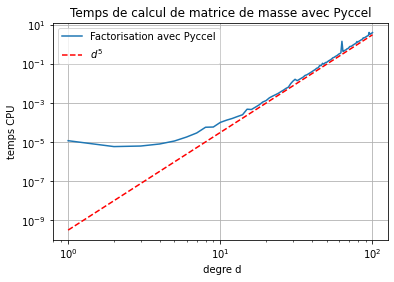

In [78]:
ax = pl.axes(xscale='log', yscale='log')
pl.plot(degre,temCPUpyccelF,label='Factorisation avec Pyccel')
pl.title("Temps de calcul de matrice de masse avec Pyccel")
pl.xlabel(" degre d")
pl.ylabel("temps CPU")
Degre=np.array(degre)
cst=3.1*(10**(-10))
Z=cst*(Degre**5)
pl.plot(degre,Z,'r--',label='$d^5$')
pl.legend()
pl.grid()
pl.show() 

**plot numba function**

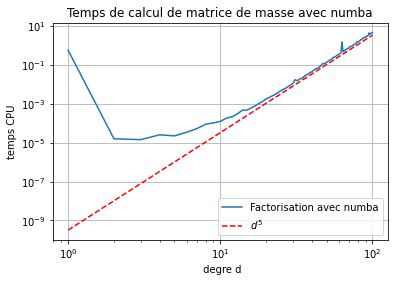

In [79]:
ax = pl.axes(xscale='log', yscale='log')
pl.plot(degre,temCPUnumbaF,label='Factorisation avec numba')
pl.title("Temps de calcul de matrice de masse avec numba")
pl.xlabel(" degre d")
pl.ylabel("temps CPU")
Degre=np.array(degre)
cst=3.21*(10**(-10))
Z=cst*(Degre**5)
pl.plot(degre,Z,'r--',label='$d^5$')
pl.legend()
pl.grid()
pl.show() 

**Plot pure function**

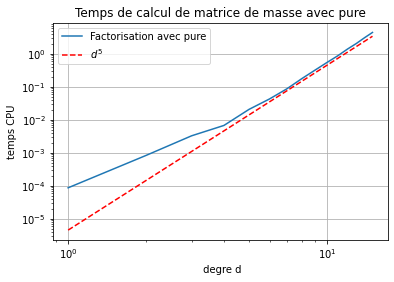

In [56]:
ax = pl.axes(xscale='log', yscale='log')
pl.plot(degre,temCPUpureF,label='Factorisation avec pure')
pl.title("Temps de calcul de matrice de masse avec pure")
pl.xlabel(" degre d")
pl.ylabel("temps CPU")
Degre=np.array(degre)
cst=4.5*(10**(-6))
Z=cst*(Degre**5)
pl.plot(degre,Z,'r--',label='$d^5$')
pl.legend()
pl.grid()
pl.show() 

**Plot pure, numba and pyccel functions**

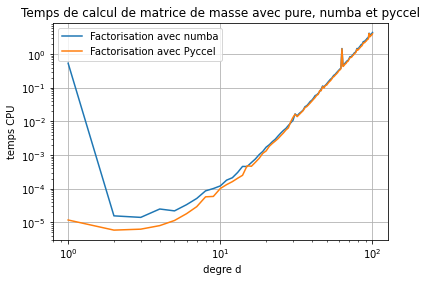

In [80]:
ax = pl.axes(xscale='log', yscale='log')
#pl.plot(degre,temCPUpureF,label='Factorisation avec pure')
pl.plot(degre,temCPUnumbaF,label='Factorisation avec numba')
pl.plot(degre,temCPUpyccelF,label='Factorisation avec Pyccel')
pl.title("Temps de calcul de matrice de masse avec pure, numba et pyccel")
pl.xlabel(" degre d")
pl.ylabel("temps CPU")
Degre=np.array(degre)
cst=4.5*(10**(-10))
Z=cst*(Degre**5)
#pl.plot(degre,Z,'r--',label='$d^5$')
pl.legend()
pl.grid()
pl.show() 